In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e4/sample_submission.csv
/kaggle/input/playground-series-s4e4/train.csv
/kaggle/input/playground-series-s4e4/test.csv


In [4]:
#hide
#! [ -e /content ]

#hide
#This imports and sets up everything you will need for this notebook
#
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *
from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random

from fastai.imports import *
np.set_printoptions(linewidth=130)

# for working with paths in Python, I recommend using `pathlib.Path`
from pathlib import Path
import os
import seaborn as sns


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import xgboost as xgb


from ipywidgets import interact


matplotlib.rc('image', cmap='Greys')

In [7]:
!ls

In [6]:
path = Path('/kaggle/input/playground-series-s4e4/')
path

Path('/kaggle/input/playground-series-s4e4')

In [8]:
#train_df = pd.read_csv(path/'train.csv',index_col='id')

train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv',index_col='id')


In [28]:
train_df

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
id,,,,,,,,,
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9
...,...,...,...,...,...,...,...,...,...
90610,M,0.335,0.235,0.075,0.1585,0.0685,0.0370,0.0450,6
90611,M,0.555,0.425,0.150,0.8790,0.3865,0.1815,0.2400,9
90612,I,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815,6


<Axes: >

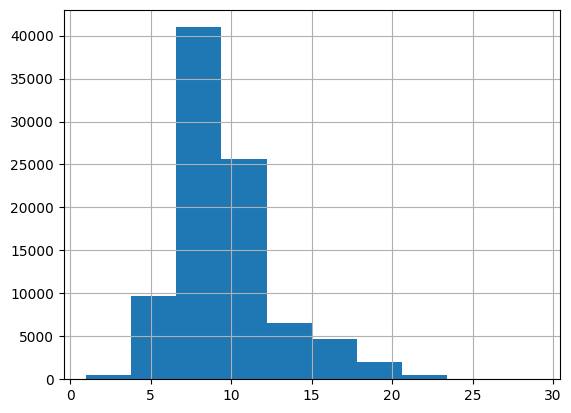

In [9]:
train_df['Rings'].hist()

In [10]:
train_df.isna().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
Rings             0
dtype: int64

In [15]:
#train_df['Rings'].value_counts(ascending=True)

In [18]:
train_df.value_counts("Rings")

Rings
9     17465
8     14499
10    12464
7      9008
11     8407
6      5411
12     4719
13     4074
5      2862
14     2507
15     2072
16     1439
4      1402
17     1175
18      848
19      639
20      507
3       386
21      255
23      180
22      108
27       41
24       29
2        29
1        25
29       24
25       22
26       18
Name: count, dtype: int64

In [17]:
train_df.describe()

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000
mean,0.517098,0.401679,0.135464,0.789035,0.340778,0.169422,0.225898,9.696794
std,0.118217,0.098026,0.038008,0.457671,0.204428,0.100909,0.130203,3.176221
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.445000,0.345000,0.110000,0.419000,0.177500,0.086500,0.120000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,0.600000,0.470000,0.160000,1.067500,0.463000,0.232500,0.305000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [ ]:
#train_df = pd.read_csv(path/'train.csv',index_col='id')

train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv',index_col='id')
cont_names,cat_names = cont_cat_split(train_df, dep_var='Rings')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Rings',
                   y_block=RegressionBlock(),
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

model = xgb.XGBClassifier(n_estimators = 100, max_depth=8, learning_rate=0.1, subsample=0.5)
xgb_model = model.fit(X_train, y_train)

In [19]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Rings')

In [20]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

In [21]:
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Rings',
                   y_block=RegressionBlock(),
                   splits=splits)

In [23]:
to.xs.iloc[:2]

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
id,,,,,,,,
4215,2,-2.304530,-2.212732,-1.982332,-1.516324,-1.47344,-1.497935,-1.545114
59842,3,0.404916,0.288336,-0.012960,0.261266,0.28066,0.274243,0.492233


In [25]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [26]:
model = xgb.XGBClassifier(n_estimators = 100, max_depth=8, learning_rate=0.1, subsample=0.5)

Use XGBRegressor instead of XGBClassifier

In [29]:
model = xgb.XGBRegressor(n_estimators = 100, max_depth=8, learning_rate=0.1, subsample=0.5)


In [30]:
xgb_model = model.fit(X_train, y_train)